In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import statistics
import random

%matplotlib inline
plt.style.use('bmh')

In [2]:
from keras.preprocessing.image import ImageDataGenerator

2023-04-26 19:09:27.503844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from skimage import exposure
from skimage.feature import local_binary_pattern
from skimage.util import img_as_ubyte
from skimage.feature import graycomatrix, graycoprops

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [5]:
import h5py

## Load data

In [6]:
h5f = h5py.File('data_h5','r')

denim_blended = h5f['denim_blended'][:]
denim = h5f['denim'][:]

knit_blended = h5f['knit_blended'][:]
knit = h5f['knit'][:]

fleece_blended = h5f['fleece_blended'][:]
fleece_poly = h5f['fleece_poly'][:]
fleece_Modal = h5f['fleece_Modal'][:]

linen = h5f['linen'][:]
linen_rayon = h5f['linen_rayon'][:]
linen_viscose = h5f['linen_viscose'][:]

leather_poly = h5f['leather_poly'][:]
leather_PU = h5f['leather_PU'][:]
leather_PVC = h5f['leather_PVC'][:]

outdoor_cotton = h5f['outdoor_cotton'][:]
outdoor_poly = h5f['outdoor_poly'][:]

# Preprocess Data 

### 1. Augment data

In [7]:
#should be np array (#imgs, pixel,pixel,1) for grey scale
def rotate_imgs (fabric, num_imgs, angle_start, angle_stop): 
    
    pixels = len(fabric[1,:,:,0]) 
    fabric_aug = np.zeros((num_imgs,pixels,pixels,3))
    
    for i in range(num_imgs): 
        angle = random.randint(angle_start, angle_stop)
        # ImageDataGenerator rotation
        datagen = ImageDataGenerator(rotation_range=angle, fill_mode='nearest')
        # iterator
        aug_iter = datagen.flow(fabric, batch_size=1)
        # generate one img with random angle
        image = next(aug_iter)[0].astype('uint8')
        fabric_aug[i,:,:,:] = image
 
    return fabric_aug

In [8]:
#should be np array (#imgs, pixel,pixel,1) for grey scale
def shift_imgs (fabric, num_imgs, width_shift, height_shift): 
    
    pixels = len(fabric[1,:,:,0]) 
    fabric_aug = np.zeros((num_imgs,pixels,pixels,3))
    
    for i in range(num_imgs): 
        width_shift = random.uniform(0.01, width_shift)
        height_shift = random.uniform(0.01, height_shift)
        # ImageDataGenerator rotation
        datagen = ImageDataGenerator(width_shift_range=width_shift, height_shift_range=height_shift)
        # iterator
        aug_iter = datagen.flow(fabric, batch_size=1)
        # generate one img with random angle
        image = next(aug_iter)[0].astype('uint8')
        fabric_aug[i,:,:,:] = image
 
    return fabric_aug

In [9]:
#should be np array (#imgs, pixel,pixel,1) for grey scale
def flip_imgs (fabric, num_imgs): 
    
    pixels = len(fabric[1,:,:,0]) 
    fabric_aug = np.zeros((num_imgs,pixels,pixels,3))
    
    for i in range(num_imgs): 
        # ImageDataGenerator rotation
        datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
        # iterator
        aug_iter = datagen.flow(fabric, batch_size=1)
        # generate one img with random angle
        image = next(aug_iter)[0].astype('uint8')
        fabric_aug[i,:,:,:] = image
 
    return fabric_aug

In [10]:
#should be np array (#imgs, pixel,pixel,1) for grey scale
def zoom_imgs (fabric, num_imgs, start_range, stop_range): 
    
    pixels = len(fabric[1,:,:,0]) 
    fabric_aug = np.zeros((num_imgs,pixels,pixels,3))
    
    for i in range(num_imgs): 
        zoom = random.uniform(start_range,stop_range)
        #stop = random.uniform(start_range+.01, stop_range)
        # ImageDataGenerator rotation
        datagen = ImageDataGenerator(zoom_range=zoom)
        # iterator
        aug_iter = datagen.flow(fabric, batch_size=1)
        # generate one img with random angle
        image = next(aug_iter)[0].astype('uint8')
        fabric_aug[i,:,:,:] = image
 
    return fabric_aug

In [11]:
def transform_fabric(fabric):
    
    #num_imgs = len(fabric)
    num_imgs = 5
    pixels = len(fabric[1,:,:,0])
    
    rotate = rotate_imgs(fabric, num_imgs, -15, 15)
    shift = shift_imgs(fabric, num_imgs, 0.2, 0.2)
    flip = flip_imgs(fabric, num_imgs)
    zoom = zoom_imgs(fabric, num_imgs, 0.05, 1)
    
    transform = np.zeros((4*num_imgs,pixels,pixels,3))
    #df_transform = pd.DataFrame()
    i = 0
    j = 0
    while j<(4*num_imgs):
        #df_transform = pd.concat([df_transform,df1,df2,df3,df4])
        transform[j,:,:] = rotate[i]
        transform[j+1,:,:] = shift[i]
        transform[j+2,:,:] = flip[i]
        transform[j+3,:,:] = zoom[i]
        j+=4
        i+=1
       
    return transform


### Add augmented data 

In [12]:
denim_blended_aug = transform_fabric(denim_blended)
denim_blended = np.vstack((denim_blended_aug, denim_blended))
denim_aug = transform_fabric(denim)
denim = np.vstack((denim, denim_aug))

knit_blended_aug = transform_fabric(knit_blended)
knit_blended = np.vstack((knit_blended_aug, knit_blended))
knit_aug = transform_fabric(knit)
knit = np.vstack((knit, knit_aug))

fleece_blended_aug = transform_fabric(fleece_blended)
fleece_blended = np.vstack((fleece_blended_aug, fleece_blended))
fleece_poly_aug = transform_fabric(fleece_poly)
fleece_poly = np.vstack((fleece_poly, fleece_poly_aug))
fleece_Modal_aug = transform_fabric(fleece_Modal)
fleece_Modal = np.vstack((fleece_Modal, fleece_Modal_aug))


linen_aug = transform_fabric(linen)
linen_blended = np.vstack((linen_aug, linen))
linen_rayon_aug = transform_fabric(linen_rayon)
linen_rayon = np.vstack((linen_rayon, linen_rayon_aug))
linen_viscose_aug = transform_fabric(linen_viscose)
linen_viscose = np.vstack((linen_viscose, linen_viscose_aug))
#linen_synthetic_aug = transform_fabric(linen_synthetic)
#linen_synthetic = np.vstack((linen_synthetic, linen_synthetic_aug))

leather_poly_aug = transform_fabric(leather_poly)
leather_poly = np.vstack((leather_poly_aug, leather_poly))
leather_PU_aug = transform_fabric(leather_PU)
leather_PU = np.vstack((leather_PU, leather_PU_aug))
leather_PVC_aug = transform_fabric(leather_PVC)
leather_PVC = np.vstack((leather_PVC, leather_PVC_aug))

outdoor_cotton_aug = transform_fabric(outdoor_cotton)
outdoor_cotton = np.vstack((outdoor_cotton, outdoor_cotton_aug))
outdoor_poly_aug = transform_fabric(outdoor_poly)
outdoor_poly = np.vstack((outdoor_poly, outdoor_poly_aug))

### Enhance images with histogram equlaization 

In [13]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [14]:
def create_gray_imgs(fabric):
    num_imgs = len(fabric)
    gray = np.zeros((num_imgs, 224, 224))
    for i in range(num_imgs):
        gray[i,:,:] = rgb2gray(fabric[i,:,:,:])
    return gray 

In [15]:
def equalize_img(image): 
    image = rgb2gray(image)
    image = image/255
    img_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03) #tried clip_limit=[0.1-1.0] (0.5 was best) too grainy if you go up very soft going down 
    
    return img_adapteq

In [16]:
def equalize_fabric(fabric): 
    N,p,p,c = fabric.shape 
    equalized = np.zeros((N,p,p))
    for n in range(N):
        image = fabric[n,:,:,:]
        equalized[n,:,:] = equalize_img(image)
        
    return equalized

In [17]:
denim_eq = equalize_fabric(denim)
denim_b_eq = equalize_fabric(denim_blended)


knit_eq = equalize_fabric(knit)
knit_b_eq = equalize_fabric(knit_blended)


fleece_blended_eq = equalize_fabric(fleece_blended)
fleece_poly_eq = equalize_fabric(fleece_poly)
fleece_Modal_eq = equalize_fabric(fleece_Modal)


linen_eq = equalize_fabric(linen)
linen_rayon_eq = equalize_fabric(linen_rayon)
linen_viscose_eq = equalize_fabric(linen_viscose)
#linen_synthetic_eq = equalize_fabric(linen_synthetic) #I think we need to get rid of this 


leather_poly_eq = equalize_fabric(leather_poly)
leather_PU_eq = equalize_fabric(leather_PU)
leather_PVC_eq = equalize_fabric(leather_PVC)


outdoor_cotton_eq = equalize_fabric(outdoor_cotton)
outdoor_poly_eq = equalize_fabric(outdoor_poly)

Text(0.5, 1.0, 'equalized')

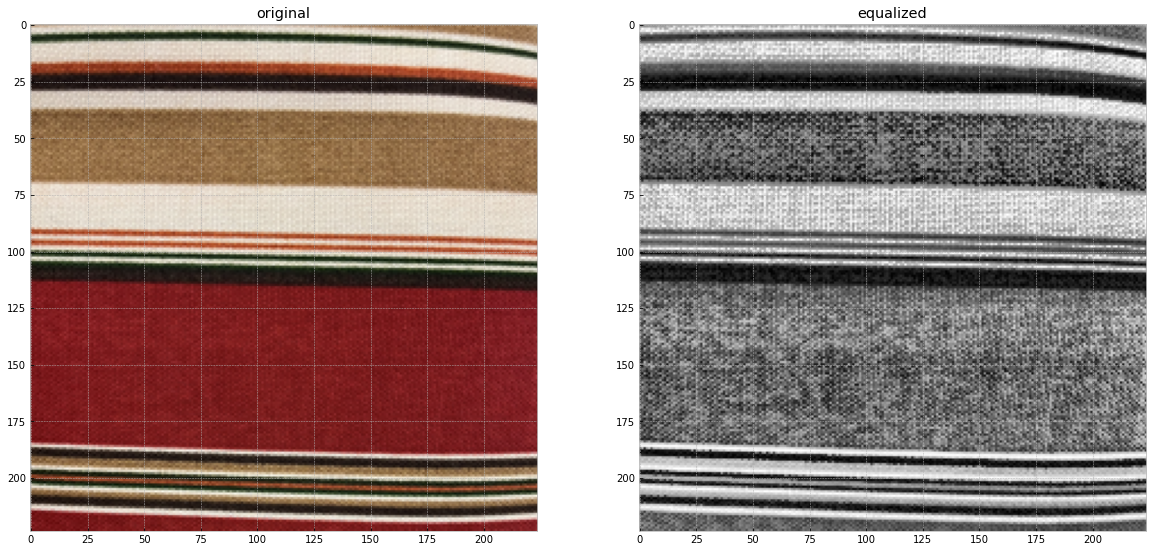

In [18]:
index = 4

fabric = outdoor_poly
fabric_eq =outdoor_poly_eq

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(fabric[index,:,:,:]/255)
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(fabric_eq[index,:,:], cmap = 'gray')
plt.title('equalized')


## Combine data 


In [19]:
def create_labels(fabric, label):
    images = len(fabric)
    labels = np.zeros((images))
    for i in range(images):
        labels[i] = label
        
    return labels

In [20]:
def create_data_matrix_eq(num_fabrics,fabric1,fabric2,fabric3,fabric4): 
    
    # create labels 
    fabric1_labels = create_labels(fabric1,0)
    fabric2_labels = create_labels(fabric2,1)
    
    if num_fabrics ==2: 
        X = np.vstack((fabric1, fabric2))
        Y = np.hstack((fabric1_labels, fabric2_labels))
    
    elif num_fabrics == 3: 
        fabric3_labels = create_labels(fabric3,2)
        X = np.vstack((fabric1, fabric2, fabric3))
        Y = np.hstack((fabric1_labels, fabric2_labels, fabric3_labels))
  
    return X, Y 
    

In [21]:
def create_data_matrix(num_fabrics,fabric1,fabric2,fabric3,fabric4): 
    
    # create gray images 
    fabric1_g = create_gray_imgs(fabric1)
    fabric2_g = create_gray_imgs(fabric2)
    
    # create labels 
    fabric1_labels = create_labels(fabric1_g,0)
    fabric2_labels = create_labels(fabric2_g,1)
    
    row = len(fabric1_g)
    row2 = len(fabric1_labels)
    
    row3 = len(fabric2_g) 
    row4 = len(fabric2_labels)
    
    if num_fabrics == 2: 
        if row != row2: 
            print('error fabric1')
        elif row3 != row4: 
            print ('error fabric 2')
        else:
            X = np.vstack((fabric1_g, fabric2_g))
            Y = np.hstack((fabric1_labels, fabric2_labels))
    
    elif num_fabrics == 3: 
        fabric3_g = create_gray_imgs(fabric3)
        fabric3_labels = create_labels(fabric3_g,2)
        X = np.vstack((fabric1_g, fabric2_g, fabric3_g))
        Y = np.hstack((fabric1_labels, fabric2_labels, fabric3_labels))
        
    elif num_fabrics == 4: 
        fabric3_g = create_gray_imgs(fabric3)
        fabric3_labels = create_labels(fabric3_g,2)
        fabric4_g = create_gray_imgs(fabric4)
        fabric4_labels = create_labels(fabric4_g,3)
        X = np.vstack((fabric1_g, fabric2_g, fabric3_g,fabric4_g))
        Y = np.hstack((fabric1_labels, fabric2_labels, fabric3_labels, fabric4_labels))
        
    
    return X, Y 
    

In [22]:
# create labels 
Y_fleece_blen = create_labels(fleece_blended, 0)
Y_fleece_poly = create_labels(fleece_poly[0:90,:,:,:], 1)
Y_fleece_Modal =  create_labels(fleece_Modal, 2)
Y_knit_blended = create_labels(knit_blended, 3)
Y_knit = create_labels(knit, 4)
Y_linen = create_labels(linen, 5)
Y_linen_rayon = create_labels(linen_rayon, 6)
Y_linen_viscose = create_labels(linen_viscose, 7)
Y_leather_poly = create_labels(leather_poly, 8)
Y_leather_PU = create_labels(leather_PU, 9)
Y_leather_PVC = create_labels(leather_PVC, 10)
Y_outdoor_cotton = create_labels(outdoor_cotton, 11)
Y_outdoor_poly = create_labels(outdoor_poly, 12)
Y_denim = create_labels(denim, 13)
Y_denim_blend = create_labels(denim_blended, 14)

In [23]:
X = np.vstack((fleece_blended_eq,fleece_poly_eq[0:90,:,:],fleece_Modal_eq,knit_b_eq,knit_eq,linen_eq,linen_rayon_eq,linen_viscose_eq,leather_poly_eq,leather_PU_eq,leather_PVC_eq,outdoor_cotton_eq,outdoor_poly_eq,denim_eq,denim_b_eq,))
Y = np.hstack((Y_fleece_blen,Y_fleece_poly,Y_fleece_Modal,Y_knit_blended,Y_knit,Y_linen,Y_linen_rayon,Y_linen_viscose,Y_leather_poly,Y_leather_PU,Y_leather_PVC,Y_outdoor_cotton,Y_outdoor_poly,Y_denim,Y_denim_blend))

In [24]:
X.shape, Y.shape

((1369, 224, 224), (1369,))

# Feature Extraction

### 1. LBP histograms  

In [25]:
def lbp_image(images,num_points,radius):
    lbps = []
    N, p, p = images.shape
    for n in range(N):
        lbp = local_binary_pattern(images[n,:,:], P=num_points, R=radius)
        lbps.append(lbp)
    
    return np.array(lbps)

In [26]:
## add note about where code is from 

def show_images_with_labels(images, labels, start_index=0):
    fig, axes = plt.subplots(ncols=7, nrows=1, figsize=(18, 2.5))

    index = start_index
    for i in range(7):
        axes[i].imshow(images[index], cmap='gray')
        axes[i].set_title([labels[index]])
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        index += 1
    plt.show()

In [27]:
def create_sub_images(image, num_sub_imgs): 
    pixel, pixel = image.shape
    total_imgs = round(num_sub_imgs**2)
    sub_pixels = round(pixel/num_sub_imgs)
    #for n in range(N): 
    start_row = 0
    stop_row = start_row + sub_pixels
    start_col = 0
    stop_col = start_col +  sub_pixels
    row = 0 
    sub_imgs = np.zeros((total_imgs,sub_pixels,sub_pixels))
    for i in range(total_imgs-1):
        width = pixel/num_sub_imgs
        sub_imgs[i,:,:] = image[start_row:stop_row,start_col:stop_col]
        #change row 
        if stop_col ==224: 
            row = row+1 
            start_col = 0
            stop_col = start_col +  sub_pixels
            start_row = row*(sub_pixels)
            stop_row = start_row + sub_pixels 
        else: 
            start_col = start_col+sub_pixels
            stop_col= stop_col + sub_pixels
            
    return sub_imgs

In [28]:
def create_histograms(fabric,num_sub_imgs,bins_per_sub_images): 
    N,p,p = fabric.shape
    fabric_hist = np.zeros((N,round(bins_per_sub_images*num_sub_imgs*num_sub_imgs)))
    for n in range(N):
        image = fabric[n,:,:]
        sub_imgs = create_sub_images(image, num_sub_imgs)
        sub_img_hist = []
        for i in range(round(num_sub_imgs**2)): 
            histogram = np.histogram(sub_imgs[i,:,:], bins=bins_per_sub_images)[0]
            sub_img_hist.append(histogram)
            
        hist1 = np.array(sub_img_hist).flatten()
        fabric_hist[n,:] = hist1
    
    return fabric_hist

In [29]:
def lbp_histograms(fabric, num_points, radius, num_sub_imgs, num_bins):
    lbp = lbp_image(fabric,num_points,radius)
    lbp_hist = create_histograms(lbp, num_sub_imgs, num_bins)
    
    return lbp_hist

### 2. GLCM

In [30]:
def GLCM_sub_imgs(sub_images, dist, angle): 
    sub_images = img_as_ubyte(sub_images/255)
    num_images, pixel, pixel = sub_images.shape
    contrast = []
    dissimilarity = []
    homogeneity = []
    ASM = []
    energy = []
    correlation = []
    for i in range(num_images): 
        glcm = graycomatrix(sub_images[i,:,:], distances = dist, angles = angle, levels = 256,
                       symmetric = True, normed = True)
        contrast.append(graycoprops(glcm, 'contrast'))
        dissimilarity.append(graycoprops(glcm, 'dissimilarity'))
        homogeneity.append(graycoprops(glcm, 'homogeneity'))
        ASM.append(graycoprops(glcm, 'ASM'))
        energy.append(graycoprops(glcm, 'energy'))
        correlation.append(graycoprops(glcm, 'correlation'))
    
    return contrast, dissimilarity, homogeneity, ASM, energy, correlation

In [31]:
def GLCM_fabric(fabric, num_sub_imgs, dist, angle):
    #fabric_g = create_gray_imgs(fabric)
    N, pixels, pixels = fabric.shape
    properties = np.zeros((N,6,round(num_sub_imgs**2)))
    for n in range(N): 
        image = fabric[n, :, :]
        sub_imgs = create_sub_images(image, num_sub_imgs)
        contrast, dissimilarity, homogeneity, ASM, energy, correlation = GLCM_sub_imgs(sub_imgs,dist,angle)
        for i in range(round(num_sub_imgs**2)): 
            properties[n,0,i]=contrast[i]
            properties[n,1,i]=dissimilarity[i]
            properties[n,2,i]=homogeneity[i]
            properties[n,3,i]= ASM[i]
            properties[n,4,i]= energy[i]
            properties[n,5,i]=correlation[i]
    
    return properties

## 3. combine features 

In [32]:
def fabric_features(X, Y, numpoints, radius): 
    
    #split data 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                       stratify = Y)
    
    #create lbp histograms 
    X_train_lbp = lbp_histograms(X_train, numpoints, radius, num_sub_imgs = 4, num_bins = 64) #tried 10 bins, 40 bins, 56 and 64 (drastically increased) 
    X_test_lbp = lbp_histograms(X_test, numpoints, radius, num_sub_imgs = 4, num_bins = 64)
    
    #create GCLM features 
    X_train_prop = GLCM_fabric(X_train, num_sub_imgs = 4, dist = [2], angle = [0])
    N,K,L = X_train_prop.shape
    X_train_prop = X_train_prop.reshape((N,K*L))
    X_test_prop = GLCM_fabric(X_test, num_sub_imgs = 4, dist = [2] , angle = [0])
    N,K,L = X_test_prop.shape
    X_test_prop = X_test_prop.reshape((N,K*L))
    
    #combine features 
    X_train = np.hstack((X_train_lbp,X_train_prop))
    X_test = np.hstack((X_test_lbp,X_test_prop))
    
    return X_train, X_test, y_train, y_test 

In [33]:
X_train,X_test,Y_train,Y_test = fabric_features(X,Y,8,1)

## PCA 

In [34]:
def find_key_features(X_train,X_test,Y_train,N_features_start): 
    N, fet = X_train.shape
    N_features = N_features_start
    check = 0
    while check<1:
    
        # Designing and training dimensionality reduction model
        pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=N))])

        pipe.fit(X_train, Y_train)

        explained_var = np.cumsum(pipe.named_steps['pca'].explained_variance_ratio_)[N_features]

        if explained_var>=0.93: 
            check = 2
            pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=N_features))])
            pipe.fit(X_train, Y_train)
            ypca = pipe.transform(X_train)
            ypca_test = pipe.transform(X_test)
        else: 
            check = 0
            N_features = N_features+2
            
    return N_features, ypca, ypca_test

In [35]:
N_fet, X_train, X_test = find_key_features(X_train, X_test, Y_train, 100)

In [36]:
N_fet

218

In [37]:
#sklearn.metrics.f1_score(y_true, y_pred)
model_svm = SVC()

model_svm = model_svm.fit(X_train, Y_train)
predicted = model_svm.predict(X_test)

In [38]:
f1_score(Y_test,predicted, average=None)

array([0.69565217, 0.70588235, 0.66666667, 0.92682927, 0.83333333,
       0.25      , 0.72      , 0.75      , 0.7826087 , 0.82352941,
       0.83870968, 0.94444444, 0.92857143, 0.8       , 0.71428571])

## train classifiers

In [39]:
def train_Models(X_train_hist, X_test_hist, y_train, y_test): 
    ###SVM 
    model_svm = SVC()
    model_svm.fit(X_train_hist, y_train)
    svm_train_accuracy = model_svm.score(X_train_hist, y_train)
    svm_test_accuracy = model_svm.score(X_test_hist, y_test)
    
    ### logistic regression
    model_logreg = LogisticRegression(max_iter=5000)
    model_logreg.fit(X_train_hist, y_train)
    logreg_train_acc = model_logreg.score(X_train_hist, y_train)
    logreg_test_acc = model_logreg.score(X_test_hist, y_test)
    
    ### KNN
    model_knn = KNeighborsClassifier(n_neighbors=1)
    model_knn.fit(X_train_hist, y_train)
    knn_train_acc = model_knn.score(X_train_hist, y_train)
    knn_test_acc =  model_knn.score(X_test_hist, y_test)
    
    return svm_train_accuracy,svm_test_accuracy,logreg_train_acc,logreg_test_acc,knn_train_acc,knn_test_acc

In [40]:
svm_train, svm_test, lr_train, lr_test, knn_train, knn_test = train_Models(X_train, X_test, 
                                                                          Y_train, Y_test)

In [41]:
print ('all fabrics\t:')
print('')
print('SVM train acc\t:', svm_train)
print('SVM test acc\t:', svm_test)
print('')
print('logistic regression train acc\t:', lr_train)
print('logistic regression test acc\t:', lr_test)
print('')
print('KNN train acc\t:', knn_train)
print('KNN test acc\t:', knn_test)

all fabrics	:

SVM train acc	: 0.915068493150685
SVM test acc	: 0.8321167883211679

logistic regression train acc	: 1.0
logistic regression test acc	: 0.8357664233576643

KNN train acc	: 1.0
KNN test acc	: 0.8540145985401459
